In [1]:
# Imports
import pandas as pd
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau, CSVLogger
import tempfile
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import rankdata
from keras import backend as be
import json
%matplotlib inline
import mpld3
mpld3.enable_notebook()

# Figure stuff
plt.rcParams["figure.figsize"] = (12,8)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}

# File stuff
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

# Training stuff
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
CHANNELS = 1
CLASSES = 10
VALIDATION_RATIO = 0.2
BATCH_SIZE = 16
VERBOSITY = 1
EPOCHS = 20

Using TensorFlow backend.


In [74]:
# Define some utility functions

def setup_gpu():
    gpu_options = tf.GPUOptions(allow_growth=True)
    config = tf.ConfigProto( device_count = {'GPU': 1, 'CPU':1} , gpu_options=gpu_options) 
    sess = tf.Session(config=config) 
    keras.backend.set_session(sess)

def setup_cpu():
    gpu_options = tf.GPUOptions(allow_growth=True)
    config = tf.ConfigProto( device_count = {'GPU': 0, 'CPU':1} , gpu_options=gpu_options) 
    sess = tf.Session(config=config) 
    keras.backend.set_session(sess)

def save_list(filename, lst):
    lst_df = pd.DataFrame(lst)
    lst_df.to_json(filename)

def load_list(filename):
    lst = pd.read_json(filename)
    return lst
setup_gpu()

In [3]:
# Loading and reshaping data.
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")

y = train_csv['label']
x = train_csv.drop(labels=['label'], axis=1)

x = x.values.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
test = test_csv.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

y = to_categorical(y, num_classes=CLASSES)

In [4]:
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=VALIDATION_RATIO, shuffle=True)
x_train = x_train / 255.0
x_validate = x_validate / 255.0

In [5]:
# Data augmentation
data_generator = ImageDataGenerator(rotation_range=2,
                                    zoom_range=0.01, 
                                    width_shift_range=0.01,
                                    height_shift_range=0.01)
data_generator.fit(x_train)

In [6]:
# Build a model

model = Sequential()

model.add(Dense(1000, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)))
model.add(Dropout(0.25))

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))


# Final layer is a softmax layer
model.add(Dense(CLASSES, activation="softmax"))

model.compile(optimizer=RMSprop(lr=0.0001,
                               rho=0.9,
                               epsilon=1e-08,
                               decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Get all dense layer names of the model.
model_layer_names = [l.name for l in model.layers if 'dense' in l.name]


## Prune weights
- Set individual weights in the weight matrix to zero. This corresponds to deleting connections as in the figure above.
- Here, to achieve sparsity of k% we rank the individual weights in weight matrix W according to their magnitude, and then set to zero the smallest k%.

- After pruning the weights, compile the new model and obtain its accuracy. 
- Store the validation and training accuracy inside of weight_val_accuracy and weight_accuracy, respectively

In [7]:
# set up GPU
setup_gpu()

weight_accuracies = []
weight_val_accuracies = []
weight_pruned_models = []
weight_epoch_training_accuracies = []
weight_epoch_validation_accuracies = []
k_perc = [.25, .50, .60, .70, .80, .90, .95, .97, .99]
# Compute for k% 
for k in k_perc:
    ranks = {}

    # Reset the model we're working with.
    pruned_model = keras.models.clone_model(model)

    # For each layer, recalculate the weights according to k and regenerate the model.
    print("Recalculating weights for k% {}".format(k))
    for n in model_layer_names:
        l = pruned_model.get_layer(n)
        w = np.array(l.get_weights()[0])
        b = np.array(l.get_weights()[1])

        ranks[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)

        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)

        ranks[l][ranks[l]<=lower_bound_rank] = 0
        ranks[l][ranks[l]>lower_bound_rank] = 1

        w = w*ranks[l]

        l.set_weights([w,b])

    print("Fitting compiled model for k% {}".format(k))
    pruned_model.compile(optimizer=RMSprop(lr=0.0001,
                               rho=0.9,
                               epsilon=1e-08,
                               decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    history = pruned_model.fit_generator(data_generator.flow(x_train, y_train, 
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validate, y_validate),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

    avg_accuracy_at_k = sum(history.history['accuracy'])/len(history.history['accuracy'])
    avg_val_accuracy_at_k = sum(history.history['val_accuracy'])/len(history.history['val_accuracy'])
    weight_accuracies.append(avg_accuracy_at_k)
    weight_val_accuracies.append(avg_val_accuracy_at_k)
    weight_pruned_models.append(pruned_model)

try:
    # Save the accuracies we've just obtained just in case we need to reload them later.
    save_list("weight_pruned_model/weight_accuracies.json", weight_accuracies)
    save_list("weight_pruned_model/weight_val_accuracies.json", weight_val_accuracies)

    for model in weight_pruned_models:
        weight_epoch_training_accuracies.append(model.history.history['accuracy'])
        weight_epoch_validation_accuracies.append(model.history.history['val_accuracy'])

    save_list("weight_pruned_model/epoch_training_accuracies.json", epoch_training_accuracies)
    save_list("weight_pruned_model/epoch_val_accuracies.json", epoch_validation_accuracies)

    for umodel, k in [unit_pruned_models, k_perc]:
        umodel.save("unit_pruned_model/model_{}".format(k))
except:
    pass

Recalculating weights for k% 0.25
Fitting compiled model for k% 0.25


W1102 22:21:55.316138 140284081907520 deprecation_wrapper.py:119] From /home/ala/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3972 - accuracy: 0.8821 - val_loss: 0.2234 - val_accuracy: 0.9340
Epoch 2/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2668 - accuracy: 0.9252 - val_loss: 0.2004 - val_accuracy: 0.9414
Epoch 3/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2386 - accuracy: 0.9319 - val_loss: 0.1876 - val_accuracy: 0.9461
Epoch 4/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2243 - accuracy: 0.9351 - val_loss: 0.2071 - val_accuracy: 0.9420
Epoch 5/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2208 - accuracy: 0.9374 - val_loss: 0.2453 - val_accuracy: 0.9337
Epoch 6/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2229 - accuracy: 0.9358 - val_loss: 0.2776 - val_accuracy: 0.9242
Epoch 7/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2259 - accuracy: 0.9343 - val_loss: 0

2100/2100 [==============================] - 107s 51ms/step - loss: 0.2280 - accuracy: 0.9339 - val_loss: 0.2918 - val_accuracy: 0.9246
Epoch 16/20
2100/2100 [==============================] - 108s 51ms/step - loss: 0.2244 - accuracy: 0.9359 - val_loss: 0.2813 - val_accuracy: 0.9242
Epoch 17/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2275 - accuracy: 0.9363 - val_loss: 0.2444 - val_accuracy: 0.9312
Epoch 18/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2278 - accuracy: 0.9349 - val_loss: 0.2739 - val_accuracy: 0.9251
Epoch 19/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2261 - accuracy: 0.9362 - val_loss: 0.2394 - val_accuracy: 0.9336
Epoch 20/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2265 - accuracy: 0.9348 - val_loss: 0.2214 - val_accuracy: 0.9365
Recalculating weights for k% 0.7
Fitting compiled model for k% 0.7
Epoch 1/20
2100/2100 [==============================] - 1

2100/2100 [==============================] - 107s 51ms/step - loss: 0.3204 - accuracy: 0.9076 - val_loss: 0.3105 - val_accuracy: 0.9052
Epoch 10/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3211 - accuracy: 0.9070 - val_loss: 0.3068 - val_accuracy: 0.9085
Epoch 11/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3153 - accuracy: 0.9087 - val_loss: 0.3432 - val_accuracy: 0.9035
Epoch 12/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3169 - accuracy: 0.9086 - val_loss: 0.3664 - val_accuracy: 0.8956
Epoch 13/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3178 - accuracy: 0.9088 - val_loss: 0.3508 - val_accuracy: 0.9007
Epoch 14/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3173 - accuracy: 0.9074 - val_loss: 0.2884 - val_accuracy: 0.9170
Epoch 15/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3149 - accuracy: 0.9095 - val_loss: 0.3118

2100/2100 [==============================] - 107s 51ms/step - loss: 0.4416 - accuracy: 0.8729 - val_loss: 0.3064 - val_accuracy: 0.9124
Epoch 4/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3989 - accuracy: 0.8876 - val_loss: 0.2856 - val_accuracy: 0.9188
Epoch 5/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3783 - accuracy: 0.8945 - val_loss: 0.2725 - val_accuracy: 0.9217
Epoch 6/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3592 - accuracy: 0.8978 - val_loss: 0.2643 - val_accuracy: 0.9232
Epoch 7/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3504 - accuracy: 0.9017 - val_loss: 0.2557 - val_accuracy: 0.9265
Epoch 8/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3401 - accuracy: 0.9033 - val_loss: 0.2525 - val_accuracy: 0.9277
Epoch 9/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3320 - accuracy: 0.9057 - val_loss: 0.2453 - val

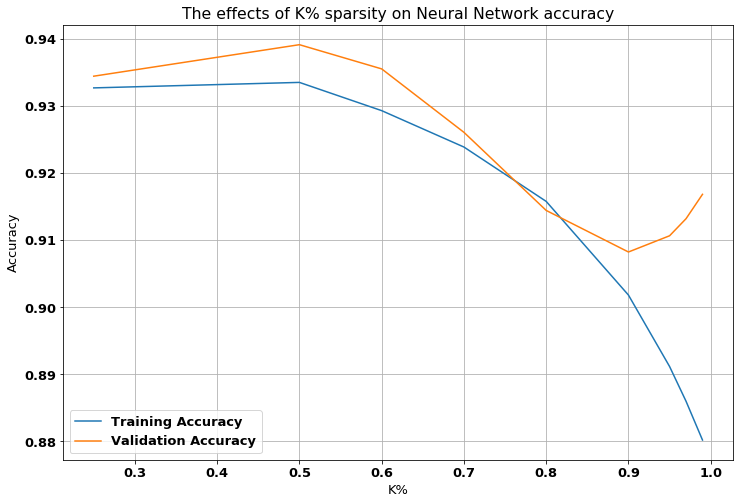

In [122]:
# Load accuracies from file
weight_accuracies = load_list("weight_pruned_model/weight_accuracies.json")[0]
weight_val_accuracies = load_list("weight_pruned_model/weight_val_accuracies.json")[0]

# Plot the accuracy of training and validation.
plt.rcParams["figure.figsize"] = (12,8)
plt.rc('font', **font)
x = k_perc
y = weight_accuracies
y2 = weight_val_accuracies
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 4))(np.unique(x)), label="Training Accuracy")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 4))(np.unique(x)), label="Validation Accuracy")
plt.xlabel("K%")
plt.ylabel("Accuracy")
plt.title("The effects of K% sparsity on accuracy (weight pruning)")
plt.legend(loc='lower left')
plt.grid()

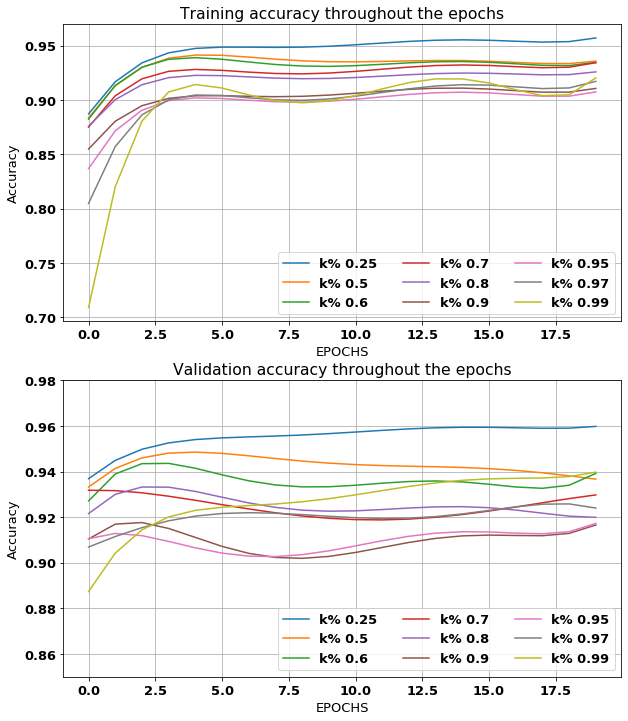

In [115]:
# Load accuracies across epochs from file
weight_epoch_training_accuracies = load_list("weight_pruned_model/epoch_training_accuracies.json")
weight_epoch_validation_accuracies = load_list("weight_pruned_model/epoch_val_accuracies.json")

plt.rcParams["figure.figsize"] = (10, 12)
plt.rc('font', **font)

fig, axs = plt.subplots(2)

k_perc_legend = ["k% " + str(s) for s in k_perc]
x = range(0, EPOCHS)
#plt.subplot(1, 2, 1)
axs[0].set_xlabel("EPOCHS")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training accuracy throughout the epochs")

axs[0].grid()
count = 0
for ea in range(0, len(weight_epoch_training_accuracies)):
    y = weight_epoch_training_accuracies.loc[ea]
    axs[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 5))(np.unique(x)), label=k_perc_legend[count])
    count += 1
axs[0].legend(ncol=3)

axs[1].set_xlabel("EPOCHS")
axs[1].set_ylim([0.85, 0.98])
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Validation accuracy throughout the epochs")
axs[1].grid()

count = 0
for eva in range(0, len(weight_epoch_validation_accuracies)):
    y2 = weight_epoch_validation_accuracies.loc[eva]
    axs[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 5))(np.unique(x)), label=k_perc_legend[count])
    count += 1
axs[1].legend(loc=4, ncol=3)
plt.show()

## Prune Neurons
- Set entire columns to zero in the weight matrix to zero, in effect deleting the corresponding output neuron.
- Here to achieve sparsity of k% we rank the columns of a weight matrix according to their L2-norm and delete the smallest k%.

- After pruning the weights, compile the new model and obtain its accuracy. 
- Store the validation and training accuracy inside of unit_val_accuracy and unit_accuracy, respectively

In [7]:
setup_gpu()
unit_accuracies = []
unit_val_accuracies = []
unit_pruned_models = []
unit_epoch_training_accuracies = []
unit_epoch_validation_accuracies = []
k_perc = [.25, .50, .60, .70, .80, .90, .95, .97, .99]
for k in k_perc:
    ranks = {}
    pruned_model = keras.models.clone_model(model)
    
    
    # for each layer, recalculate the removal of the neurons. 
    # Set entire columns to zero in the weight matrix to zero, 
    # in effect deleting the corresponding output neuron.
    
    # Here to achieve sparsity of k% we rank the columns of a 
    # weight matrix according to their L2-norm and delete the smallest k%.
    print("Recalculating layer sparsity for k% {}".format(k))
    for n in model_layer_names:
        l = pruned_model.get_layer(n)
        w = np.array(l.get_weights()[0])
        b = np.array(l.get_weights()[1])
        
        norm = LA.norm(w,axis=0)
        norm = np.tile(norm, (w.shape[0], 1))
        ranks[l] = (rankdata(norm, method='dense') - 1).astype(int).reshape(norm.shape)
        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        w = w*ranks[l]
        l.set_weights([w,b])

    
    print("Fitting compiled model for k% {}".format(k))
    pruned_model.compile(optimizer=RMSprop(lr=0.0001,
                               rho=0.9,
                               epsilon=1e-08,
                               decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    history = pruned_model.fit_generator(data_generator.flow(x_train, y_train, 
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validate, y_validate),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE)
    
    avg_accuracy_at_k = sum(history.history['accuracy'])/len(history.history['accuracy'])
    avg_val_accuracy_at_k = sum(history.history['val_accuracy']) / len(history.history['accuracy'])
    unit_accuracies.append(avg_accuracy_at_k)
    unit_val_accuracies.append(avg_val_accuracy_at_k)
    unit_pruned_models.append(pruned_model)

try:
    # Save the accuracies we've just obtained just in case we need to reload them later.
    save_list("unit_pruned_model/unit_accuracies.json", unit_accuracies)
    save_list("unit_pruned_model/unit_val_accuracies.json", unit_val_accuracies)

    for model in unit_pruned_models:
        unit_epoch_training_accuracies.append(model.history.history['accuracy'])
        unit_epoch_validation_accuracies.append(model.history.history['val_accuracy'])

    save_list("unit_pruned_model/epoch_training_accuracies.json", unit_epoch_training_accuracies)
    save_list("unit_pruned_model/epoch_val_accuracies.json", unit_epoch_validation_accuracies)

    for umodel, k in zip(unit_pruned_models, k_perc):
        umodel.save("unit_pruned_model/model_{}".format(k))
except:
    pass

Recalculating layer sparsity for k% 0.25
Fitting compiled model for k% 0.25


W1103 06:25:29.494219 140339780581184 deprecation_wrapper.py:119] From /home/ala/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.5707 - accuracy: 0.8350 - val_loss: 0.2487 - val_accuracy: 0.9319
Epoch 2/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3087 - accuracy: 0.9111 - val_loss: 0.2203 - val_accuracy: 0.9390
Epoch 3/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2640 - accuracy: 0.9257 - val_loss: 0.2022 - val_accuracy: 0.9427
Epoch 4/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2424 - accuracy: 0.9298 - val_loss: 0.1935 - val_accuracy: 0.9439
Epoch 5/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2270 - accuracy: 0.9342 - val_loss: 0.2093 - val_accuracy: 0.9365
Epoch 6/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2281 - accuracy: 0.9343 - val_loss: 0.2517 - val_accuracy: 0.9292
Epoch 7/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.2235 - accuracy: 0.9350 - val_loss: 0

2100/2100 [==============================] - 107s 51ms/step - loss: 0.3206 - accuracy: 0.9060 - val_loss: 0.2823 - val_accuracy: 0.9268
Epoch 16/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3227 - accuracy: 0.9053 - val_loss: 0.2891 - val_accuracy: 0.9217
Epoch 17/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3194 - accuracy: 0.9060 - val_loss: 0.2902 - val_accuracy: 0.9218
Epoch 18/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3171 - accuracy: 0.9071 - val_loss: 0.3271 - val_accuracy: 0.9149
Epoch 19/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3182 - accuracy: 0.9079 - val_loss: 0.2742 - val_accuracy: 0.9233
Epoch 20/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.3316 - accuracy: 0.9048 - val_loss: 0.2817 - val_accuracy: 0.9225
Recalculating layer sparsity for k% 0.7
Fitting compiled model for k% 0.7
Epoch 1/20
2100/2100 [============================

2100/2100 [==============================] - 107s 51ms/step - loss: 0.6182 - accuracy: 0.8029 - val_loss: 0.3183 - val_accuracy: 0.9040
Epoch 10/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6163 - accuracy: 0.8015 - val_loss: 0.3078 - val_accuracy: 0.9073
Epoch 11/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6274 - accuracy: 0.7983 - val_loss: 0.3141 - val_accuracy: 0.9071
Epoch 12/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6362 - accuracy: 0.7965 - val_loss: 0.3140 - val_accuracy: 0.9067
Epoch 13/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6407 - accuracy: 0.7891 - val_loss: 0.3163 - val_accuracy: 0.9026
Epoch 14/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6475 - accuracy: 0.7876 - val_loss: 0.3150 - val_accuracy: 0.9050
Epoch 15/20
2100/2100 [==============================] - 107s 51ms/step - loss: 0.6592 - accuracy: 0.7863 - val_loss: 0.3175

2100/2100 [==============================] - 107s 51ms/step - loss: 2.3014 - accuracy: 0.1123 - val_loss: 2.3019 - val_accuracy: 0.1083
Epoch 4/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3019 - val_accuracy: 0.1083
Epoch 5/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3012 - accuracy: 0.1123 - val_loss: 2.3019 - val_accuracy: 0.1083
Epoch 6/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3011 - accuracy: 0.1123 - val_loss: 2.3019 - val_accuracy: 0.1083
Epoch 7/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3011 - accuracy: 0.1123 - val_loss: 2.3019 - val_accuracy: 0.1083
Epoch 8/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3010 - accuracy: 0.1123 - val_loss: 2.3020 - val_accuracy: 0.1083
Epoch 9/20
2100/2100 [==============================] - 107s 51ms/step - loss: 2.3010 - accuracy: 0.1123 - val_loss: 2.3020 - val

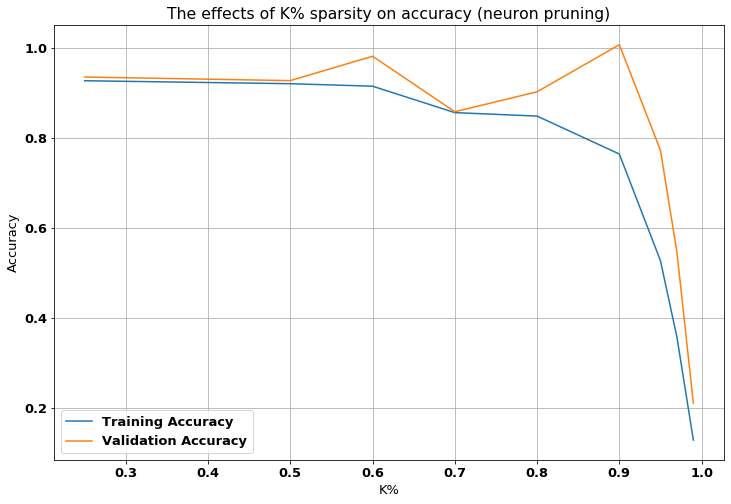

In [126]:
# Load accuracies across epochs from file
weight_epoch_training_accuracies = load_list("unit_pruned_model/unit_accuracies.json")
weight_epoch_validation_accuracies = load_list("unit_pruned_model/unit_val_accuracies.json")

plt.rcParams["figure.figsize"] = (12, 8)
plt.rc('font', **font)
x = k_perc
y = unit_accuracies
y2 = unit_val_accuracies
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 5))(np.unique(x)), label="Training Accuracy")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 5))(np.unique(x)), label="Validation Accuracy")
plt.xlabel("K%")
plt.ylabel("Accuracy")
plt.title("The effects of K% sparsity on accuracy (neuron pruning)")
plt.legend(loc='lower left')
plt.grid()

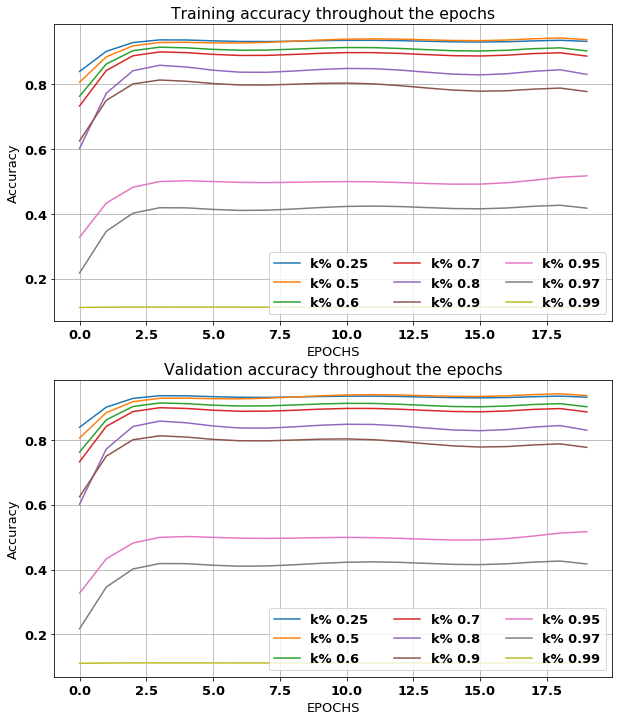

In [124]:
# Load accuracies across epochs from file
unit_epoch_training_accuracies = load_list("unit_pruned_model/epoch_training_accuracies.json")
unit_epoch_validation_accuracies = load_list("unit_pruned_model/epoch_val_accuracies.json")


plt.rcParams["figure.figsize"] = (10, 12)
plt.rc('font', **font)

fig, axs = plt.subplots(2)
k_perc_legend = ["k% " + str(s) for s in k_perc]

x = range(0, EPOCHS)
#plt.subplot(1, 2, 1)
axs[0].set_xlabel("EPOCHS")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training accuracy throughout the epochs")
axs[0].grid()

count = 0
for ea in range(0, len(unit_epoch_training_accuracies)):
    y = unit_epoch_training_accuracies.loc[ea]
    axs[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 6))(np.unique(x)), label=k_perc_legend[count])
    count += 1
axs[0].legend(ncol=3)


#axs[1].legend(k_perc, )
axs[1].set_xlabel("EPOCHS")
#axs[1].set_ylim([0.85, 0.98])
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Validation accuracy throughout the epochs")
axs[1].grid()

count = 0
for eva in range(0, len(unit_epoch_validation_accuracies)):
    y2 = unit_epoch_training_accuracies.loc[eva]
    axs[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 6))(np.unique(x)), label=k_perc_legend[count])
    count += 1
axs[1].legend(loc=4, ncol=3)
plt.show()